# **1. Introduction**

The CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided into 10 classes. Each class contains 6,000 images. The training set contains 50,000 images, while the test sets provides 10,000 images. This image taken from the CIFAR repository ( https://www.cs.toronto.edu/~kriz/cifar.html ). This is a classification problem with 10 classes (muti-label classification). We can take a view on this image for more comprehension of the dataset.

![image.png](https://miro.medium.com/v2/resize:fit:640/format:webp/1*r8S5tF_6naagKOnlIcGXoQ.png)


The challenge is to recognize previously unseen images and assign them to one of the 10 classes.

Ok Let's get started.

# **2. Libraries**

In [53]:
# Working with directories
import os
from copy import deepcopy

# Data manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Preprocessing Step
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Modelling Step
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.models import Model

# Callback Step
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# Report Step
from sklearn.metrics import classification_report

# **3. Memory Growth Limit**

In [2]:
# Setting memory growth 'True' so that when we run tensorflow model, it won't result in 'ResourceExhaustedError'.
gpus = tf.config.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **4. Load Data**

Since we want to add Image Augmentation to generalize data and use `train_test_split`, it is very easy to handle if it is `DataFrame` type, but we must keep track of corresponding path of images in specific column (in this case, fullpath).

In [3]:
def load_image_dataframe(directory : str) -> pd.DataFrame:
    result = {
        'fullpath' : [],
        'labels' : []
    }

    for label in os.listdir(directory):
        for img in os.listdir(os.path.join(directory, label)):
            spec_path = os.path.join(directory, label, img)

            result['fullpath'].append(spec_path)
            result['labels'].append(label)
    
    return pd.DataFrame(result)

In [4]:
train = load_image_dataframe('./train')
test = load_image_dataframe('./test')

In [5]:
# Setting (approximate values):
# Train -> 84 %
# Validation, Test (each) -> 8 %

X_train = train
X_validation, X_test = train_test_split(test, test_size=0.5, stratify=test['labels'].values)

# **5. Image Augmentation (Preprocessing)**

In [147]:
# Data augmentation step.

def image_generator(image_size : tuple = (224, 224), batch_size : int = 32, preprocess_input=None):
    """
    * If preprocess_input is None, It is set to apply default transformation, Otherwise following specific preprocess step.

    ----
    Returns : `train_generator, validation_generator, test_generator` as Generator Type.
    """

    # Means, adding no parameter
    if preprocess_input == -1:
        datagen_train = ImageDataGenerator(
            preprocessing_function=lambda image : cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        )

    elif preprocess_input is not None:
        datagen_train = ImageDataGenerator(
            preprocessing_function=preprocess_input
        )
    
    else:
        # Since we will use flow_from_directory and provide full path. Images will be read by OpenCv. Default it reads as BGR channel
        # In this case, color_mode doesn't work. So we will use preprocessing_function to convert BGR to RGB.
        datagen_train = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1 / 255,
            preprocessing_function=lambda image : cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        )

    datagen_test = deepcopy(datagen_train)

    train_generator = datagen_train.flow_from_dataframe(
        X_train,
        directory='.',
        x_col='fullpath',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical'
    )

    validation_generator = datagen_test.flow_from_dataframe(
        X_validation,
        directory='.',
        x_col='fullpath',
        y_col='labels',
        target_size=image_size,
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical'
    )

    test_generator = datagen_test.flow_from_dataframe(
            X_test,
            directory='.',
            x_col='fullpath',
            y_col='labels',
            target_size=image_size,
            batch_size=batch_size,
            color_mode= 'rgb',
            class_mode='categorical'
        )
    
    return train_generator, validation_generator, test_generator

# **6. Visualizing --> (Graphical Representation)**

In [7]:
# To show how data looks.
train_generator, validation_generator, test_generator = image_generator(image_size=(32, 32))

Found 50000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.


In [8]:
# To see label infos as (key -> label_index, value -> corresponding label) and vice versa
label_info_num = {
    v : k for k, v in train_generator.class_indices.items()
}

label_info_alpha = {
    k : v for k, v in train_generator.class_indices.items()
}

In [9]:
print(label_info_num)
print(label_info_alpha)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


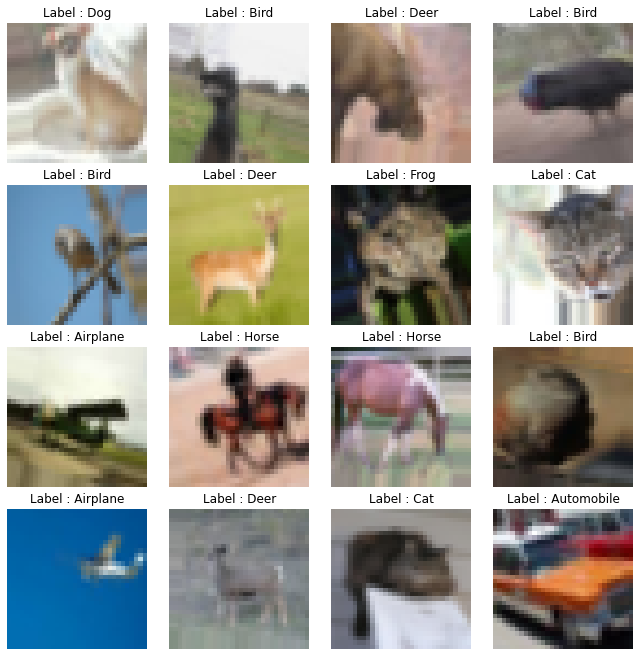

In [10]:
img, labels = next(train_generator)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(9, 9), constrained_layout=True)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(img[i])
    
    spec_label = np.argmax(labels[i])

    ax.set_title('Label : {}'.format(label_info_num[spec_label].capitalize()))
    ax.set_axis_off()

# **7. Modelling**

## **7.1 Tools**

In [11]:
# Plotting Loss & Accuracy graph

def loss_accuracy_graph(history):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 5))

    axs[0].plot(history.history['loss'], label='Training Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')

    axs[1].plot(history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    axs[0].legend()
    axs[1].legend()

    plt.show()

# Accuracy Score
def model_accuracy_score(model):
    loss, acc = model.evaluate(test_generator)

    print('Loss : {}, Accuracy : {}'.format(round(loss, 2), round(acc, 2)))

## **7.2 ResNet-50**

ResNet-50 is deep convolutional neural network that allows `skip connection` to be able update parameters easily (Eventually prevents vanishing/exploding gradient problem).
It creates blocks in feature extractor part, so that it keeps track of blocks input and give it to blocks output. With this way, there is no information loss (Eventually minimizing noise).

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/0*9LqUp7XyEx1QNc6A.png)

For more information, you can check out this paper (https://blog.devgenius.io/resnet50-6b42934db431)

In [12]:
# ResNet-50 Architecture usually works with (224, 224, 3) image size, so we will transform our image to that size by using `ImageDataGenerator`.

image_size = (224, 224)
batch_size = 16

train_generator, validation_generator, test_generator = image_generator(
    image_size=image_size,
    batch_size=batch_size,
    preprocess_input=tf.keras.applications.resnet.preprocess_input
)

Found 50000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.


Here, we will only need `feature map` to extract important information. So setting `include_top` to False.
- We will use `fine tuning` to update feature maps even more.
- Also, we still need to add `Dense` Layers to be able to classify our image to single input.

In [15]:
resnet_v2 = ResNet50(include_top=False, weights='imagenet', input_shape=image_size + (3, ))

In [16]:
x = GlobalAveragePooling2D() (resnet_v2.output)
x = Flatten() (x)

x = Dense(units=1024, activation='relu') (x)
x = Dropout(0.3) (x)

x = Dense(units=256, activation='relu') (x)
x = Dropout(0.3) (x)

x = Dense(units=10, activation='softmax') (x)

resnet_v2_final = Model(inputs=resnet_v2.input, outputs=x)

After Creating `Model`, we compile it. In this case:
- **Optimizer** : Stochastic Gradient Descent (SGD)
- **Loss** : Categorical CrossEntropy
- **Metrics** : Accuracy_score

In [17]:
resnet_v2_final.compile(optimizer=tf.keras.optimizers.SGD(),
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])

Creating `Callbacks` by adding : 
- **ModelCheckPoint** : To save Model
- **Early Stoppig** : To stop fitting process when reaching certaing `patience`
- **TensorBoard** : To see important ascepts while training

In [18]:
callbacks = [
    ModelCheckpoint('./Model_results/resnet-v2-best.h5', 
                    monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3,
                  verbose=1, restore_best_weights=True),
    TensorBoard(log_dir='./logs')
]

In [19]:
# Assigning model's output to get history.

history_resnet_v2 = resnet_v2_final.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15, steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator), callbacks=callbacks
)

Epoch 1/15
3125/3125 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.8395
Epoch 1: val_loss improved from inf to 0.22710, saving model to ./Model_results\resnet-v2-best.h5
3125/3125 [==============================] - 955s 301ms/step - loss: 0.4853 - accuracy: 0.8395 - val_loss: 0.2271 - val_accuracy: 0.9216
Epoch 2/15
3125/3125 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9385
Epoch 2: val_loss improved from 0.22710 to 0.18016, saving model to ./Model_results\resnet-v2-best.h5
3125/3125 [==============================] - 939s 301ms/step - loss: 0.1898 - accuracy: 0.9385 - val_loss: 0.1802 - val_accuracy: 0.9408
Epoch 3/15
3125/3125 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9650
Epoch 3: val_loss did not improve from 0.18016
3125/3125 [==============================] - 941s 301ms/step - loss: 0.1057 - accuracy: 0.9650 - val_loss: 0.1993 - val_accuracy: 0.9364
Epoch 4/15
3125/3125 [==========================

Here we can see, Model performed well in both training and validation dataset. In order to see full details, we can use `TensorBoard` to analyze. 
To analyze, We should do following step :
- Open terminal and write `tensorboard --logdir logs`
- After that , it will generate localhost link. Inside, you can check details.

You can also use this created model by loading it in following, so you can experience it too:
-   `model = tf.keras.models.load_model('./Model_results/resnet-v2-best.h5')`

# **8. Evaluating Model**

We can see Loss & Accuracy Graph by using `history` instance that assigned to `model.fit`.

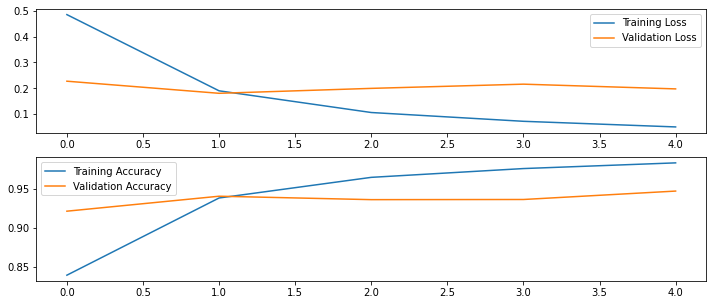

In [21]:
loss_accuracy_graph(history_resnet_v2)

Now, we can test our model in unseen data and check if it gives satisfying result.

In [39]:
model_accuracy_score(resnet_v2_final)

313/313 [==============================] - 74s 227ms/step - loss: 0.1991 - accuracy: 0.9390
Loss : 0.2, Accuracy : 0.94


As we can see, it perfoms very well in test data as well.
In order to see `confusion matrix` and `classification report`, we first need to iterate over every batch in `test_generator` and in each iteration, we predict its values, add it to `y_true` `y_pred`. Then, creating confusion matrix from those values. We cannot evaluate with `test_generator` as it is generator, so when predict it , there will be misindexing in `y_true` and `y_pred` labels.

In [47]:
def _true_predict_labels(generator):
    y_true, y_pred = [], []

    for i in range(len(generator)):
        X_orig, y_orig = generator.next()

        predicted_labels = np.argmax(resnet_v2_final.predict(X_orig, verbose=0), axis=1)
        y_orig = np.argmax(y_orig, axis=1)

        for j in range(len(y_orig)):
            y_true.append(y_orig[j])
            y_pred.append(predicted_labels[j])

    return y_true, y_pred

def confusion_matrix(generator):
    y_true, y_pred = _true_predict_labels(generator)

    cm = np.zeros((10, 10), dtype=int)

    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_label = y_pred[i]

        cm[true_label][pred_label]+= 1
    
    return cm

In [48]:
def plot_confusion_matrix(dataset, classes, cmap=plt.cm.Blues):
    """
    * Plot confusion matrix and corresponding colorbar.
    """
    cm = confusion_matrix(dataset)

    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(cm, cmap=cmap)

    # ColorBar
    ax.figure.colorbar(img, ax=ax)
    thresh = cm.max() // 2

    # Adding Design parameters to axis.
    ax.set(
        xticks=np.arange(cm.shape[0]),
        yticks=np.arange(cm.shape[1]),
        xticklabels=classes, 
        yticklabels=classes,
        xlabel='Predicted Labels',
        ylabel='True Labels',
        title='Confusion Matrix'
    )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

    ax.set_xlabel(ax.get_xlabel(), fontsize=12, fontfamily='serif')
    ax.set_ylabel(ax.get_ylabel(), fontsize=12, fontfamily='serif')

    ax.set_title(ax.get_title(), fontsize=12, fontfamily='serif')

    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(i, j, cm[i][j], fontsize=14, va='center', ha='center', color='white' if cm[i][j] > thresh else 'black')
            
    plt.show()

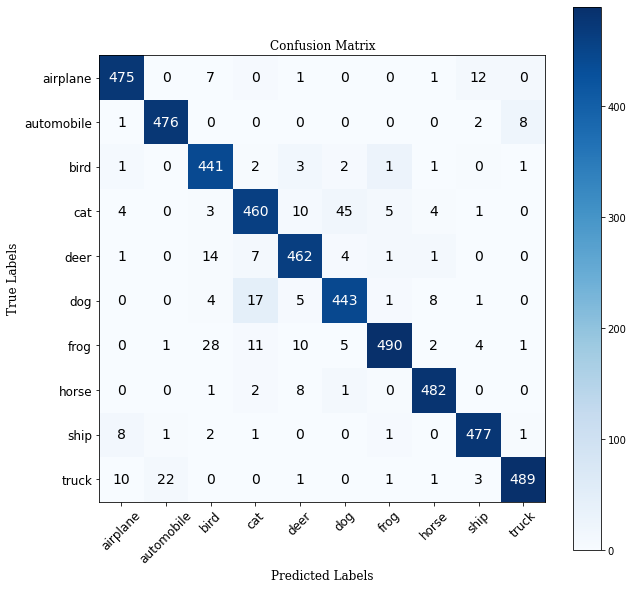

In [49]:
class_names = test_generator.class_indices.keys()

plot_confusion_matrix(test_generator, classes=class_names)

As we can see, Model predicted very well in `test dataset` and it is perfectly illustrated in `confusion_matrix`. 
 Also, we can see that mostly model's accuracy goes down because of `dog` and `cat` classification since when true label is `cat`.
We can also see `recall` and `precision` of each labels by using `classification_report`.

In [50]:
# Classification Report
y_true, y_pred = _true_predict_labels(test_generator)

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.96      0.95      0.95       500
  automobile       0.98      0.95      0.96       500
        bird       0.98      0.88      0.93       500
         cat       0.86      0.92      0.89       500
        deer       0.94      0.92      0.93       500
         dog       0.92      0.89      0.91       500
        frog       0.89      0.98      0.93       500
       horse       0.98      0.96      0.97       500
        ship       0.97      0.95      0.96       500
       truck       0.93      0.98      0.95       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



It would also be very interesting to see which pictures that model predicted `True` or `False` in test dataset.

In [151]:
def show_images(size : tuple[int, int], case : bool):

    fig, axs = plt.subplots(nrows=size[0], ncols=size[1], figsize=(12, 12))
    _flatten_axs = axs.flatten()

    test_gen_orig = image_generator(image_size, size[0] * size[1], -1)[2]

    preprocessing_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet.preprocess_input
    )
    ax_ind = 0

    while ax_ind < size[0] * size[1]:
        X_test_orig, y_test_orig = test_gen_orig.next()
        
        X_test_modified = preprocessing_datagen.flow(X_test_orig, batch_size=size[0] * size[1]).next()

        y_test_orig = np.argmax(y_test_orig, axis=1)

        predicted_label = np.argmax(resnet_v2_final.predict(X_test_modified, verbose=0), axis=1)
        label_ind = 0

        while ax_ind < size[0] * size[1] and label_ind < size[0] * size[1]:
            enter_statement = 0

            if case and predicted_label[label_ind] == y_test_orig[label_ind]:
                enter_statement = 1

            elif not case and predicted_label[label_ind] != y_test_orig[label_ind]:
                enter_statement = 2
            
            if enter_statement:
                _flatten_axs[ax_ind].imshow(X_test_orig[label_ind].astype(int))

                _flatten_axs[ax_ind].text(ax_ind // size[0] + 20, ax_ind % size[1] - 30, 'Label : {}'.format(label_info_num[y_test_orig[label_ind]]).capitalize(), 
                                        color='green')
                _flatten_axs[ax_ind].text(ax_ind // size[0] + 10, ax_ind % size[1] - 10, 'Predicted : {}'.format(label_info_num[predicted_label[label_ind]]).capitalize(), 
                                        color= 'green' if enter_statement == 1 else 'red')

                _flatten_axs[ax_ind].set_axis_off()  
                ax_ind+= 1

            label_ind+= 1
    
    fig.tight_layout()

Found 50000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.


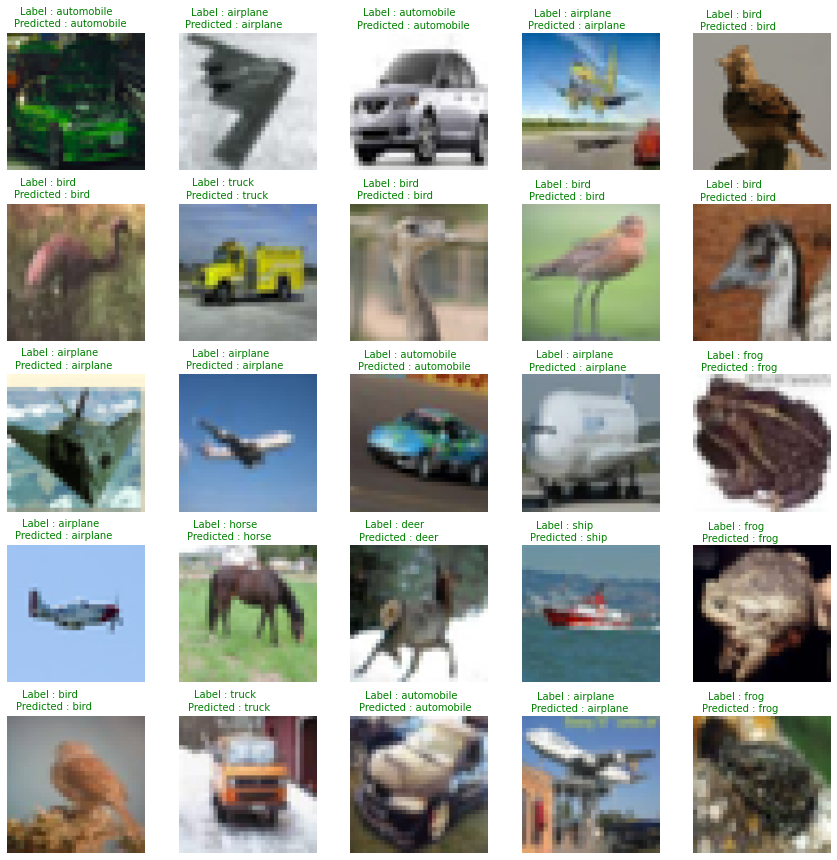

In [153]:
show_images((5, 5), case=True)

Found 50000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.


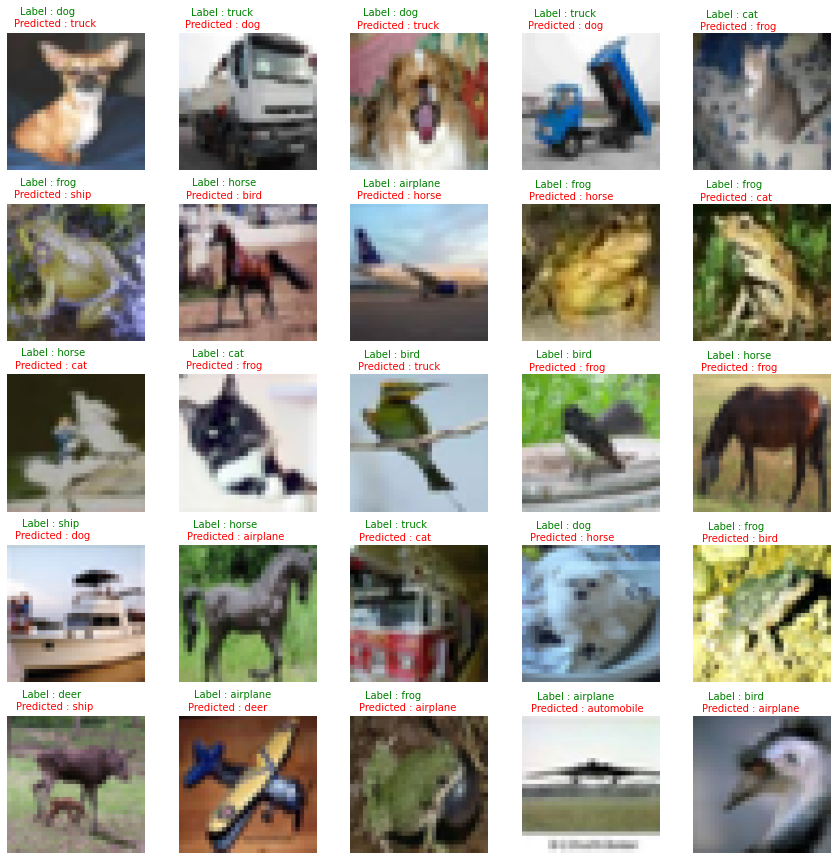

In [155]:
show_images((5, 5), case=False)